### import library

In [26]:
library(siggenes)
library(plotly)
library(survival)
library(MASS)
library(survAUC)
library(coin)
library(samr)
library(HDclassif)

In [27]:
#view all dataframe
options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)

---
### data import

In [28]:
clinical1 <- read.csv("data.csv", header = TRUE)
head(clinical1)

bcr.patient.barcode,yearstobirth,vitalstatus,daystodeath,daystolastfollowup,tumortissuesite,pathologicstage,pathologyTstage,pathologyNstage,pathologyMstage,gender,histologicaltype,extrathyroidalextension,residualtumor,numberoflymphnodes,multifocality,tumorsize,race,ethnicity,name,days,age.group,BRAF
TCGA.BJ.A0YZ,65,0,NA,754,thyroid,stage ii,t2,n0,m0,male,thyroid papillary carcinoma . classical/usual,none,r0,NA,unifocal,NA,white,not hispanic or latino,TCGA.BJ.A0YZ.01A,754,60.69,0
TCGA.BJ.A0Z0,55,0,NA,419,thyroid,stage ii,t2,n0,mx,male,thyroid papillary carcinoma . classical/usual,none,r0,0,unifocal,NA,NA,not hispanic or latino,TCGA.BJ.A0Z0.01A,419,50.59,0
TCGA.BJ.A0Z2,57,0,NA,1514,thyroid,stage ivc,t2,n0,m1,male,thyroid papillary carcinoma . follicular (>= 99% follicular patterned),none,rx,NA,unifocal,2.8,black or african american,not hispanic or latino,TCGA.BJ.A0Z2.01A,1514,50.59,0
TCGA.BJ.A0Z3,33,0,NA,497,thyroid,stage i,t1,n0,m0,female,thyroid papillary carcinoma . classical/usual,none,rx,0,multifocal,1.3,white,not hispanic or latino,TCGA.BJ.A0Z3.01A,497,30.39,1
TCGA.BJ.A0Z5,58,0,NA,448,thyroid,stage iii,t3,n1a,m0,male,thyroid papillary carcinoma . classical/usual,NA,NA,4,NA,NA,white,not hispanic or latino,TCGA.BJ.A0Z5.01A,448,50.59,0
TCGA.BJ.A0Z9,57,0,NA,1257,thyroid,stage iii,t3,n0,mx,female,thyroid papillary carcinoma . tall cell (>= 50% tall cell features),minimal (t3),r1,0,multifocal,2.8,white,not hispanic or latino,TCGA.BJ.A0Z9.01A,1257,50.59,1


In [29]:
clinical2 <- clinical1[, c("multifocality", "BRAF", "name")]
clinical2$name <- substr(clinical1$name, 1, 15)
clinical2$key <- row.names(clinical1)
head(clinical2)

multifocality,BRAF,name,key
unifocal,0,TCGA.BJ.A0YZ.01,1
unifocal,0,TCGA.BJ.A0Z0.01,2
unifocal,0,TCGA.BJ.A0Z2.01,3
multifocal,1,TCGA.BJ.A0Z3.01,4
NA,0,TCGA.BJ.A0Z5.01,5
multifocal,1,TCGA.BJ.A0Z9.01,6


In [30]:
# converting stage & focality

clinical2$PN <- as.character(clinical1$pathologyNstage)
clinical2$PN[clinical1$pathologyNstage %in% c("n1", "n1a", "n1b")] <- "n1"

clinical2$PT <- as.character(clinical1$pathologyTstage)
clinical2$PT[clinical1$pathologyTstage %in% c("t1", "t1a", "t1b")] <- "t1"
clinical2$PT[clinical1$pathologyTstage %in% c("t4", "t4a")] <- "t4"

clinical2$PT2 <- as.character(clinical2$PT)
clinical2$PT2[clinical2$PT %in% c("t1", "t2")] <- "t1 & t2"
clinical2$PT2[clinical2$PT %in% c("t3", "t4")] <- "t3 & t4"

clinical2$STAGE <- as.character(clinical1$pathologicstage)
clinical2$STAGE[clinical1$pathologicstage %in% c("stage iv", "stage iva", "stage ivc")] <- "stage iv"

clinical2$STAGE2 <- as.character(clinical2$STAGE)
clinical2$STAGE2[clinical2$STAGE %in% c("stage i", "stage ii")] <- "stage i & ii"
clinical2$STAGE2[clinical2$STAGE %in% c("stage iii", "stage iv")] <- "stage iii & iv"


clinical2$focality <- as.character(clinical1$multifocality)
clinical2$focality[clinical1$multifocality == "multifocal"] <- 1
clinical2$focality[clinical1$multifocality == "unifocal"] <- 0
clinical2$focality <- as.numeric(clinical2$focality)

In [31]:
head(clinical2)

multifocality,BRAF,name,key,PN,PT,PT2,STAGE,STAGE2,focality
unifocal,0,TCGA.BJ.A0YZ.01,1,n0,t2,t1 & t2,stage ii,stage i & ii,0
unifocal,0,TCGA.BJ.A0Z0.01,2,n0,t2,t1 & t2,stage ii,stage i & ii,0
unifocal,0,TCGA.BJ.A0Z2.01,3,n0,t2,t1 & t2,stage iv,stage iii & iv,0
multifocal,1,TCGA.BJ.A0Z3.01,4,n0,t1,t1 & t2,stage i,stage i & ii,1
NA,0,TCGA.BJ.A0Z5.01,5,n1,t3,t3 & t4,stage iii,stage iii & iv,NA
multifocal,1,TCGA.BJ.A0Z9.01,6,n0,t3,t3 & t4,stage iii,stage iii & iv,1


In [32]:
#separate BRAF

clinical_p <- clinical2[clinical2$BRAF %in% "1",]
clinical_n <- clinical2[clinical2$BRAF %in% "0",]
head(clinical_p)
head(clinical_n)

,multifocality,BRAF,name,key,PN,PT,PT2,STAGE,STAGE2,focality
4,multifocal,1,TCGA.BJ.A0Z3.01,4,n0,t1,t1 & t2,stage i,stage i & ii,1
6,multifocal,1,TCGA.BJ.A0Z9.01,6,n0,t3,t3 & t4,stage iii,stage iii & iv,1
8,unifocal,1,TCGA.BJ.A0ZB.01,8,n1,t3,t3 & t4,stage iv,stage iii & iv,0
12,NA,1,TCGA.BJ.A0ZH.01,12,n1,t2,t1 & t2,stage iv,stage iii & iv,NA
15,multifocal,1,TCGA.BJ.A18Z.01,15,n1,t3,t3 & t4,stage iv,stage iii & iv,1
19,unifocal,1,TCGA.BJ.A28R.01,19,n0,t1,t1 & t2,stage i,stage i & ii,0


,multifocality,BRAF,name,key,PN,PT,PT2,STAGE,STAGE2,focality
1,unifocal,0,TCGA.BJ.A0YZ.01,1,n0,t2,t1 & t2,stage ii,stage i & ii,0
2,unifocal,0,TCGA.BJ.A0Z0.01,2,n0,t2,t1 & t2,stage ii,stage i & ii,0
3,unifocal,0,TCGA.BJ.A0Z2.01,3,n0,t2,t1 & t2,stage iv,stage iii & iv,0
5,NA,0,TCGA.BJ.A0Z5.01,5,n1,t3,t3 & t4,stage iii,stage iii & iv,NA
7,multifocal,0,TCGA.BJ.A0ZA.01,7,n0,t2,t1 & t2,stage ii,stage i & ii,1
9,NA,0,TCGA.BJ.A0ZC.01,9,n0,t1,t1 & t2,stage i,stage i & ii,NA


---
### loading miRNA

In [33]:
load("miRNA.RData")

In [34]:
#miRNA df name col 분리
name <- rownames(miRNA)
rownames(miRNA) <- NULL
miRNA <- cbind(name,miRNA)

In [35]:
head(miRNA)

name,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,hsa-let-7g,hsa-let-7i,hsa-mir-1-2,hsa-mir-100,hsa-mir-101-1,hsa-mir-101-2,hsa-mir-103-1,hsa-mir-103-2,hsa-mir-106a,hsa-mir-106b,hsa-mir-107,hsa-mir-10a,hsa-mir-10b,hsa-mir-1179,hsa-mir-1180,hsa-mir-1181,hsa-mir-1224,hsa-mir-1226,hsa-mir-1228,hsa-mir-1229,hsa-mir-1245,hsa-mir-1247,hsa-mir-1248,hsa-mir-1249,hsa-mir-1251,hsa-mir-1254,hsa-mir-125a,hsa-mir-125b-1,hsa-mir-125b-2,hsa-mir-126,hsa-mir-1262,hsa-mir-1266,hsa-mir-127,hsa-mir-1270-1,hsa-mir-1270-2,hsa-mir-1271,hsa-mir-1274b,hsa-mir-1275,hsa-mir-1277,hsa-mir-128-1,hsa-mir-128-2,hsa-mir-1287,hsa-mir-1288,hsa-mir-129-1,hsa-mir-129-2,hsa-mir-1291,hsa-mir-1292,hsa-mir-1296,hsa-mir-1301,hsa-mir-1304,hsa-mir-1306,hsa-mir-1307,hsa-mir-130a,hsa-mir-130b,hsa-mir-132,hsa-mir-133a-1,hsa-mir-133a-2,hsa-mir-133b,hsa-mir-134,hsa-mir-135a-1,hsa-mir-135a-2,hsa-mir-135b,hsa-mir-136,hsa-mir-138-1,hsa-mir-138-2,hsa-mir-139,hsa-mir-140,hsa-mir-141,hsa-mir-142,hsa-mir-143,hsa-mir-144,hsa-mir-145,hsa-mir-1468,hsa-mir-146a,hsa-mir-146b,hsa-mir-147b,hsa-mir-148a,hsa-mir-148b,hsa-mir-149,hsa-mir-150,hsa-mir-151,hsa-mir-152,hsa-mir-153-1,hsa-mir-153-2,hsa-mir-154,hsa-mir-155,hsa-mir-15a,hsa-mir-15b,hsa-mir-16-1,hsa-mir-16-2,...,hsa-mir-497,hsa-mir-499,hsa-mir-500a,hsa-mir-500b,hsa-mir-501,hsa-mir-502,hsa-mir-503,hsa-mir-504,hsa-mir-505,hsa-mir-506,hsa-mir-508,hsa-mir-509-1,hsa-mir-509-2,hsa-mir-509-3,hsa-mir-511-1,hsa-mir-511-2,hsa-mir-514-1,hsa-mir-514-2,hsa-mir-514-3,hsa-mir-532,hsa-mir-539,hsa-mir-542,hsa-mir-545,hsa-mir-548b,hsa-mir-548e,hsa-mir-548j,hsa-mir-548o,hsa-mir-548q,hsa-mir-548v,hsa-mir-550a-1,hsa-mir-550a-2,hsa-mir-551b,hsa-mir-570,hsa-mir-574,hsa-mir-576,hsa-mir-577,hsa-mir-579,hsa-mir-580,hsa-mir-581,hsa-mir-582,hsa-mir-584,hsa-mir-585,hsa-mir-589,hsa-mir-590,hsa-mir-592,hsa-mir-598,hsa-mir-605,hsa-mir-616,hsa-mir-618,hsa-mir-624,hsa-mir-625,hsa-mir-627,hsa-mir-628,hsa-mir-629,hsa-mir-632,hsa-mir-639,hsa-mir-642a,hsa-mir-643,hsa-mir-651,hsa-mir-652,hsa-mir-653,hsa-mir-654,hsa-mir-659,hsa-mir-660,hsa-mir-664,hsa-mir-671,hsa-mir-675,hsa-mir-676,hsa-mir-7-1,hsa-mir-7-2,hsa-mir-7-3,hsa-mir-708,hsa-mir-744,hsa-mir-758,hsa-mir-760,hsa-mir-765,hsa-mir-766,hsa-mir-769,hsa-mir-874,hsa-mir-877,hsa-mir-887,hsa-mir-889,hsa-mir-891a,hsa-mir-9-1,hsa-mir-9-2,hsa-mir-92a-1,hsa-mir-92a-2,hsa-mir-92b,hsa-mir-93,hsa-mir-935,hsa-mir-937,hsa-mir-939,hsa-mir-940,hsa-mir-942,hsa-mir-944,hsa-mir-95,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b
TCGA-4C-A93U-01A-11R-A39B-13,5954.66,11895.20,6031.335,5887.396,2471.328,730.7689,2358.667,25.18938,9810.296,923.4262,3680.6949,4.705709,7469.898,13082.148,118.19634,27710.54,7.196967,6.366548,355.9731,56.46851,6056.801,50894.18,0.000000,42.90499,0.000000,0.000000,2.768064,0.000000,1.937645,1.107226,2.768064,2.491258,1.660839,34.87761,0.276806,1930.7248,3773.425,27.68064,6794.214,0.276806,8.857805,685.372691,1.107226,0.000000,3.598483,0.553613,0.000000,2.768064,62.28144,39.30651,15.77797,0.553613,0.553613,0.830419,2.768064,1.384032,4.428903,9.965031,0.830419,4.152096,1142.3801,194.87172,16.885191,68.09438,5.536128,0.276806,0.553613,149.752272,536.7276,24.08216,692.8465,34.600802,12.733095,9.688225,93.00696,839.5539,1630.943,1777.6508,35985.94,145.87698,1327.8404,1.107226,173.00401,61028.0646,1.107226,28806.97,192.9341,5.536128,288.98590,2021.240,193.2109,0.553613,3.598483,5.259322,348.77609,435.9701,301.4422,1356.6283,13.840321,...,13.840321,0.276806,174.94166,6.920160,25.74300,4.982516,6.643354,0.000000,26.85022,0.000000,29.618287,4.152096,4.152096,5.536128,14.117127,15.224353,3.321677,6.366548,6.089741,610.0813,7.196967,182.6922,0.276806,1.107226,0.276806,0.553613,0.000000,0.553613,0.830419,2.491258,0.553613,42.074576,0.553613,110.44576,11.349063,0.553613,0.276806,1.107226,0.000000,69.47841,64.77270,0.000000,34.32400,20.483675,12.179482,62.55825,0.000000,1.937645,0.830419,0.830419,98.81989,1.937645,13.00990,52.31641,0.000000,0.000000,0.276806,0.830419,3

In [36]:
#miRNA name 형식 변경
#TCGA-DJ-A2Q5-01A-11R-A18B-13 type >>> TCGA.BJ.A0YZ.01 type(clinical2)
miRNA$name <- gsub("-", ".", miRNA$name)
miRNA$name <- substr(miRNA$name, 1, 15)

In [37]:
head(miRNA)

name,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,hsa-let-7g,hsa-let-7i,hsa-mir-1-2,hsa-mir-100,hsa-mir-101-1,hsa-mir-101-2,hsa-mir-103-1,hsa-mir-103-2,hsa-mir-106a,hsa-mir-106b,hsa-mir-107,hsa-mir-10a,hsa-mir-10b,hsa-mir-1179,hsa-mir-1180,hsa-mir-1181,hsa-mir-1224,hsa-mir-1226,hsa-mir-1228,hsa-mir-1229,hsa-mir-1245,hsa-mir-1247,hsa-mir-1248,hsa-mir-1249,hsa-mir-1251,hsa-mir-1254,hsa-mir-125a,hsa-mir-125b-1,hsa-mir-125b-2,hsa-mir-126,hsa-mir-1262,hsa-mir-1266,hsa-mir-127,hsa-mir-1270-1,hsa-mir-1270-2,hsa-mir-1271,hsa-mir-1274b,hsa-mir-1275,hsa-mir-1277,hsa-mir-128-1,hsa-mir-128-2,hsa-mir-1287,hsa-mir-1288,hsa-mir-129-1,hsa-mir-129-2,hsa-mir-1291,hsa-mir-1292,hsa-mir-1296,hsa-mir-1301,hsa-mir-1304,hsa-mir-1306,hsa-mir-1307,hsa-mir-130a,hsa-mir-130b,hsa-mir-132,hsa-mir-133a-1,hsa-mir-133a-2,hsa-mir-133b,hsa-mir-134,hsa-mir-135a-1,hsa-mir-135a-2,hsa-mir-135b,hsa-mir-136,hsa-mir-138-1,hsa-mir-138-2,hsa-mir-139,hsa-mir-140,hsa-mir-141,hsa-mir-142,hsa-mir-143,hsa-mir-144,hsa-mir-145,hsa-mir-1468,hsa-mir-146a,hsa-mir-146b,hsa-mir-147b,hsa-mir-148a,hsa-mir-148b,hsa-mir-149,hsa-mir-150,hsa-mir-151,hsa-mir-152,hsa-mir-153-1,hsa-mir-153-2,hsa-mir-154,hsa-mir-155,hsa-mir-15a,hsa-mir-15b,hsa-mir-16-1,hsa-mir-16-2,...,hsa-mir-497,hsa-mir-499,hsa-mir-500a,hsa-mir-500b,hsa-mir-501,hsa-mir-502,hsa-mir-503,hsa-mir-504,hsa-mir-505,hsa-mir-506,hsa-mir-508,hsa-mir-509-1,hsa-mir-509-2,hsa-mir-509-3,hsa-mir-511-1,hsa-mir-511-2,hsa-mir-514-1,hsa-mir-514-2,hsa-mir-514-3,hsa-mir-532,hsa-mir-539,hsa-mir-542,hsa-mir-545,hsa-mir-548b,hsa-mir-548e,hsa-mir-548j,hsa-mir-548o,hsa-mir-548q,hsa-mir-548v,hsa-mir-550a-1,hsa-mir-550a-2,hsa-mir-551b,hsa-mir-570,hsa-mir-574,hsa-mir-576,hsa-mir-577,hsa-mir-579,hsa-mir-580,hsa-mir-581,hsa-mir-582,hsa-mir-584,hsa-mir-585,hsa-mir-589,hsa-mir-590,hsa-mir-592,hsa-mir-598,hsa-mir-605,hsa-mir-616,hsa-mir-618,hsa-mir-624,hsa-mir-625,hsa-mir-627,hsa-mir-628,hsa-mir-629,hsa-mir-632,hsa-mir-639,hsa-mir-642a,hsa-mir-643,hsa-mir-651,hsa-mir-652,hsa-mir-653,hsa-mir-654,hsa-mir-659,hsa-mir-660,hsa-mir-664,hsa-mir-671,hsa-mir-675,hsa-mir-676,hsa-mir-7-1,hsa-mir-7-2,hsa-mir-7-3,hsa-mir-708,hsa-mir-744,hsa-mir-758,hsa-mir-760,hsa-mir-765,hsa-mir-766,hsa-mir-769,hsa-mir-874,hsa-mir-877,hsa-mir-887,hsa-mir-889,hsa-mir-891a,hsa-mir-9-1,hsa-mir-9-2,hsa-mir-92a-1,hsa-mir-92a-2,hsa-mir-92b,hsa-mir-93,hsa-mir-935,hsa-mir-937,hsa-mir-939,hsa-mir-940,hsa-mir-942,hsa-mir-944,hsa-mir-95,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b
TCGA.4C.A93U.01,5954.66,11895.20,6031.335,5887.396,2471.328,730.7689,2358.667,25.18938,9810.296,923.4262,3680.6949,4.705709,7469.898,13082.148,118.19634,27710.54,7.196967,6.366548,355.9731,56.46851,6056.801,50894.18,0.000000,42.90499,0.000000,0.000000,2.768064,0.000000,1.937645,1.107226,2.768064,2.491258,1.660839,34.87761,0.276806,1930.7248,3773.425,27.68064,6794.214,0.276806,8.857805,685.372691,1.107226,0.000000,3.598483,0.553613,0.000000,2.768064,62.28144,39.30651,15.77797,0.553613,0.553613,0.830419,2.768064,1.384032,4.428903,9.965031,0.830419,4.152096,1142.3801,194.87172,16.885191,68.09438,5.536128,0.276806,0.553613,149.752272,536.7276,24.08216,692.8465,34.600802,12.733095,9.688225,93.00696,839.5539,1630.943,1777.6508,35985.94,145.87698,1327.8404,1.107226,173.00401,61028.0646,1.107226,28806.97,192.9341,5.536128,288.98590,2021.240,193.2109,0.553613,3.598483,5.259322,348.77609,435.9701,301.4422,1356.6283,13.840321,...,13.840321,0.276806,174.94166,6.920160,25.74300,4.982516,6.643354,0.000000,26.85022,0.000000,29.618287,4.152096,4.152096,5.536128,14.117127,15.224353,3.321677,6.366548,6.089741,610.0813,7.196967,182.6922,0.276806,1.107226,0.276806,0.553613,0.000000,0.553613,0.830419,2.491258,0.553613,42.074576,0.553613,110.44576,11.349063,0.553613,0.276806,1.107226,0.000000,69.47841,64.77270,0.000000,34.32400,20.483675,12.179482,62.55825,0.000000,1.937645,0.830419,0.830419,98.81989,1.937645,13.00990,52.31641,0.000000,0.000000,0.276806,0.830419,3.044871,14.39

In [38]:
count.zero <- sapply(1:ncol(miRNA), function(i) sum(miRNA[, i] == 0)) 
selected.mirna <- names(miRNA)[which(count.zero/nrow(miRNA) < 0.1)]
del.mirna <- setdiff(names(miRNA), selected.mirna)

In [39]:
mirna <- miRNA[, selected.mirna]
#mirna[mirna == 0] <- NA
mirna$key <- row.names(mirna)

In [40]:
head(mirna)

name,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,hsa-let-7g,hsa-let-7i,hsa-mir-1-2,hsa-mir-100,hsa-mir-101-1,hsa-mir-101-2,hsa-mir-103-1,hsa-mir-103-2,hsa-mir-106a,hsa-mir-106b,hsa-mir-107,hsa-mir-10a,hsa-mir-10b,hsa-mir-1179,hsa-mir-1180,hsa-mir-1224,hsa-mir-1226,hsa-mir-1247,hsa-mir-1248,hsa-mir-1249,hsa-mir-1251,hsa-mir-1254,hsa-mir-125a,hsa-mir-125b-1,hsa-mir-125b-2,hsa-mir-126,hsa-mir-1266,hsa-mir-127,hsa-mir-1270-1,hsa-mir-1270-2,hsa-mir-1271,hsa-mir-1274b,hsa-mir-1277,hsa-mir-128-1,hsa-mir-128-2,hsa-mir-1287,hsa-mir-1288,hsa-mir-129-1,hsa-mir-129-2,hsa-mir-1291,hsa-mir-1292,hsa-mir-1296,hsa-mir-1301,hsa-mir-1306,hsa-mir-1307,hsa-mir-130a,hsa-mir-130b,hsa-mir-132,hsa-mir-133a-1,hsa-mir-133b,hsa-mir-134,hsa-mir-135a-1,hsa-mir-135a-2,hsa-mir-135b,hsa-mir-136,hsa-mir-138-1,hsa-mir-138-2,hsa-mir-139,hsa-mir-140,hsa-mir-141,hsa-mir-142,hsa-mir-143,hsa-mir-144,hsa-mir-145,hsa-mir-1468,hsa-mir-146a,hsa-mir-146b,hsa-mir-148a,hsa-mir-148b,hsa-mir-149,hsa-mir-150,hsa-mir-151,hsa-mir-152,hsa-mir-153-2,hsa-mir-155,hsa-mir-15a,hsa-mir-15b,hsa-mir-16-1,hsa-mir-16-2,hsa-mir-17,hsa-mir-181a-1,hsa-mir-181a-2,hsa-mir-181b-1,hsa-mir-181b-2,hsa-mir-181c,hsa-mir-181d,hsa-mir-182,hsa-mir-183,hsa-mir-185,hsa-mir-186,...,hsa-mir-424,hsa-mir-425,hsa-mir-429,hsa-mir-431,hsa-mir-4326,hsa-mir-450a-1,hsa-mir-450a-2,hsa-mir-450b,hsa-mir-451,hsa-mir-452,hsa-mir-454,hsa-mir-455,hsa-mir-484,hsa-mir-486,hsa-mir-491,hsa-mir-493,hsa-mir-495,hsa-mir-497,hsa-mir-499,hsa-mir-500a,hsa-mir-500b,hsa-mir-501,hsa-mir-502,hsa-mir-503,hsa-mir-505,hsa-mir-508,hsa-mir-509-1,hsa-mir-509-2,hsa-mir-509-3,hsa-mir-511-1,hsa-mir-511-2,hsa-mir-514-1,hsa-mir-514-2,hsa-mir-514-3,hsa-mir-532,hsa-mir-542,hsa-mir-548b,hsa-mir-548v,hsa-mir-550a-1,hsa-mir-550a-2,hsa-mir-551b,hsa-mir-574,hsa-mir-576,hsa-mir-577,hsa-mir-582,hsa-mir-584,hsa-mir-585,hsa-mir-589,hsa-mir-590,hsa-mir-592,hsa-mir-598,hsa-mir-616,hsa-mir-624,hsa-mir-625,hsa-mir-627,hsa-mir-628,hsa-mir-629,hsa-mir-639,hsa-mir-642a,hsa-mir-643,hsa-mir-651,hsa-mir-652,hsa-mir-653,hsa-mir-654,hsa-mir-659,hsa-mir-660,hsa-mir-664,hsa-mir-671,hsa-mir-675,hsa-mir-676,hsa-mir-7-1,hsa-mir-7-2,hsa-mir-708,hsa-mir-744,hsa-mir-758,hsa-mir-760,hsa-mir-766,hsa-mir-769,hsa-mir-874,hsa-mir-877,hsa-mir-887,hsa-mir-889,hsa-mir-891a,hsa-mir-9-1,hsa-mir-9-2,hsa-mir-92a-1,hsa-mir-92a-2,hsa-mir-92b,hsa-mir-93,hsa-mir-935,hsa-mir-937,hsa-mir-939,hsa-mir-940,hsa-mir-942,hsa-mir-95,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b,key
TCGA.4C.A93U.01,5954.66,11895.20,6031.335,5887.396,2471.328,730.7689,2358.667,25.18938,9810.296,923.4262,3680.6949,4.705709,7469.898,13082.148,118.19634,27710.54,7.196967,6.366548,355.9731,56.46851,6056.801,50894.18,0.000000,42.90499,0.000000,2.768064,2.768064,2.491258,1.660839,34.87761,0.276806,1930.7248,3773.425,27.68064,6794.214,8.857805,685.372691,1.107226,0.000000,3.598483,0.553613,2.768064,62.28144,39.30651,15.77797,0.553613,0.553613,0.830419,2.768064,1.384032,4.428903,9.965031,4.152096,1142.3801,194.87172,16.885191,68.09438,5.536128,0.553613,149.752272,536.7276,24.08216,692.8465,34.600802,12.733095,9.688225,93.00696,839.5539,1630.943,1777.6508,35985.94,145.87698,1327.8404,1.107226,173.00401,61028.0646,28806.97,192.9341,5.536128,288.98590,2021.240,193.2109,3.598483,348.77609,435.9701,301.4422,1356.6283,13.840321,552.7824,7360.006,2287.805,1135.7367,16.885191,113.76744,22.42132,14914.330,6181.641,69.75522,297.0133,...,88.57805,480.53594,130.65263,6.920160,3.875290,3.044871,3.044871,8.027386,1155.3900,37.92248,11.902676,82.21151,63.388670,145.60018,2.214451,13.563514,7.750580,13.840321,0.276806,174.94166,6.920160,25.74300,4.982516,6.643354,26.85022,29.618287,4.152096,4.152096,5.536128,14.117127,15.224353,3.321677,6.366548,6.089741,610.0813,182.6922,1.107226,0.830419,2.491258,0.553613,42.074576,110.44576,11.349063,0.553613,69.47841,64.77270,0.000000,34.32400,20.483675,12.179482,62.55825,1.937645,0.830419,98.81989,1.937645,13.00990,52.31641,0.000000,0.27680

In [41]:
clinical3 <- merge(clinical2, mirna, by.x = "name", by.y = "name", all.x = TRUE)
head(clinical3, n=50L)
save(clinical3, file = "clinical3.RData")
load("clinical3.RData")

name,multifocality,BRAF,key.x,PN,PT,PT2,STAGE,STAGE2,focality,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,hsa-let-7g,hsa-let-7i,hsa-mir-1-2,hsa-mir-100,hsa-mir-101-1,hsa-mir-101-2,hsa-mir-103-1,hsa-mir-103-2,hsa-mir-106a,hsa-mir-106b,hsa-mir-107,hsa-mir-10a,hsa-mir-10b,hsa-mir-1179,hsa-mir-1180,hsa-mir-1224,hsa-mir-1226,hsa-mir-1247,hsa-mir-1248,hsa-mir-1249,hsa-mir-1251,hsa-mir-1254,hsa-mir-125a,hsa-mir-125b-1,hsa-mir-125b-2,hsa-mir-126,hsa-mir-1266,hsa-mir-127,hsa-mir-1270-1,hsa-mir-1270-2,hsa-mir-1271,hsa-mir-1274b,hsa-mir-1277,hsa-mir-128-1,hsa-mir-128-2,hsa-mir-1287,hsa-mir-1288,hsa-mir-129-1,hsa-mir-129-2,hsa-mir-1291,hsa-mir-1292,hsa-mir-1296,hsa-mir-1301,hsa-mir-1306,hsa-mir-1307,hsa-mir-130a,hsa-mir-130b,hsa-mir-132,hsa-mir-133a-1,hsa-mir-133b,hsa-mir-134,hsa-mir-135a-1,hsa-mir-135a-2,hsa-mir-135b,hsa-mir-136,hsa-mir-138-1,hsa-mir-138-2,hsa-mir-139,hsa-mir-140,hsa-mir-141,hsa-mir-142,hsa-mir-143,hsa-mir-144,hsa-mir-145,hsa-mir-1468,hsa-mir-146a,hsa-mir-146b,hsa-mir-148a,hsa-mir-148b,hsa-mir-149,hsa-mir-150,hsa-mir-151,hsa-mir-152,hsa-mir-153-2,hsa-mir-155,hsa-mir-15a,hsa-mir-15b,hsa-mir-16-1,hsa-mir-16-2,hsa-mir-17,hsa-mir-181a-1,...,hsa-mir-424,hsa-mir-425,hsa-mir-429,hsa-mir-431,hsa-mir-4326,hsa-mir-450a-1,hsa-mir-450a-2,hsa-mir-450b,hsa-mir-451,hsa-mir-452,hsa-mir-454,hsa-mir-455,hsa-mir-484,hsa-mir-486,hsa-mir-491,hsa-mir-493,hsa-mir-495,hsa-mir-497,hsa-mir-499,hsa-mir-500a,hsa-mir-500b,hsa-mir-501,hsa-mir-502,hsa-mir-503,hsa-mir-505,hsa-mir-508,hsa-mir-509-1,hsa-mir-509-2,hsa-mir-509-3,hsa-mir-511-1,hsa-mir-511-2,hsa-mir-514-1,hsa-mir-514-2,hsa-mir-514-3,hsa-mir-532,hsa-mir-542,hsa-mir-548b,hsa-mir-548v,hsa-mir-550a-1,hsa-mir-550a-2,hsa-mir-551b,hsa-mir-574,hsa-mir-576,hsa-mir-577,hsa-mir-582,hsa-mir-584,hsa-mir-585,hsa-mir-589,hsa-mir-590,hsa-mir-592,hsa-mir-598,hsa-mir-616,hsa-mir-624,hsa-mir-625,hsa-mir-627,hsa-mir-628,hsa-mir-629,hsa-mir-639,hsa-mir-642a,hsa-mir-643,hsa-mir-651,hsa-mir-652,hsa-mir-653,hsa-mir-654,hsa-mir-659,hsa-mir-660,hsa-mir-664,hsa-mir-671,hsa-mir-675,hsa-mir-676,hsa-mir-7-1,hsa-mir-7-2,hsa-mir-708,hsa-mir-744,hsa-mir-758,hsa-mir-760,hsa-mir-766,hsa-mir-769,hsa-mir-874,hsa-mir-877,hsa-mir-887,hsa-mir-889,hsa-mir-891a,hsa-mir-9-1,hsa-mir-9-2,hsa-mir-92a-1,hsa-mir-92a-2,hsa-mir-92b,hsa-mir-93,hsa-mir-935,hsa-mir-937,hsa-mir-939,hsa-mir-940,hsa-mir-942,hsa-mir-95,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b,key.y
,,NA,503,,,,,,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
,,NA,504,,,,,,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
,,NA,501,,,,,,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,N

In [42]:
clinical3 <- clinical3[1:ncol(clinical3)-1]

In [43]:
ncol(clinical3)
nrow(clinical3)

[1] 348

[1] 509

In [44]:
#focality na remove
clinical3 <- clinical3[!is.na(clinical3$focality), ]

In [45]:
#separating by BRAF
clinical_p <- clinical3[clinical3$BRAF %in% "1",]
clinical_n <- clinical3[clinical3$BRAF %in% "0",]
head(clinical_p)
head(clinical_n)

,name,multifocality,BRAF,key.x,PN,PT,PT2,STAGE,STAGE2,focality,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,hsa-let-7g,hsa-let-7i,hsa-mir-1-2,hsa-mir-100,hsa-mir-101-1,hsa-mir-101-2,hsa-mir-103-1,hsa-mir-103-2,hsa-mir-106a,hsa-mir-106b,hsa-mir-107,hsa-mir-10a,hsa-mir-10b,hsa-mir-1179,hsa-mir-1180,hsa-mir-1224,hsa-mir-1226,hsa-mir-1247,hsa-mir-1248,hsa-mir-1249,hsa-mir-1251,hsa-mir-1254,hsa-mir-125a,hsa-mir-125b-1,hsa-mir-125b-2,hsa-mir-126,hsa-mir-1266,hsa-mir-127,hsa-mir-1270-1,hsa-mir-1270-2,hsa-mir-1271,hsa-mir-1274b,hsa-mir-1277,hsa-mir-128-1,hsa-mir-128-2,hsa-mir-1287,hsa-mir-1288,hsa-mir-129-1,hsa-mir-129-2,hsa-mir-1291,hsa-mir-1292,hsa-mir-1296,hsa-mir-1301,hsa-mir-1306,hsa-mir-1307,hsa-mir-130a,hsa-mir-130b,hsa-mir-132,hsa-mir-133a-1,hsa-mir-133b,hsa-mir-134,hsa-mir-135a-1,hsa-mir-135a-2,hsa-mir-135b,hsa-mir-136,hsa-mir-138-1,hsa-mir-138-2,hsa-mir-139,hsa-mir-140,hsa-mir-141,hsa-mir-142,hsa-mir-143,hsa-mir-144,hsa-mir-145,hsa-mir-1468,hsa-mir-146a,hsa-mir-146b,hsa-mir-148a,hsa-mir-148b,hsa-mir-149,hsa-mir-150,hsa-mir-151,hsa-mir-152,hsa-mir-153-2,hsa-mir-155,hsa-mir-15a,hsa-mir-15b,hsa-mir-16-1,hsa-mir-16-2,hsa-mir-17,hsa-mir-181a-1,...,hsa-mir-423,hsa-mir-424,hsa-mir-425,hsa-mir-429,hsa-mir-431,hsa-mir-4326,hsa-mir-450a-1,hsa-mir-450a-2,hsa-mir-450b,hsa-mir-451,hsa-mir-452,hsa-mir-454,hsa-mir-455,hsa-mir-484,hsa-mir-486,hsa-mir-491,hsa-mir-493,hsa-mir-495,hsa-mir-497,hsa-mir-499,hsa-mir-500a,hsa-mir-500b,hsa-mir-501,hsa-mir-502,hsa-mir-503,hsa-mir-505,hsa-mir-508,hsa-mir-509-1,hsa-mir-509-2,hsa-mir-509-3,hsa-mir-511-1,hsa-mir-511-2,hsa-mir-514-1,hsa-mir-514-2,hsa-mir-514-3,hsa-mir-532,hsa-mir-542,hsa-mir-548b,hsa-mir-548v,hsa-mir-550a-1,hsa-mir-550a-2,hsa-mir-551b,hsa-mir-574,hsa-mir-576,hsa-mir-577,hsa-mir-582,hsa-mir-584,hsa-mir-585,hsa-mir-589,hsa-mir-590,hsa-mir-592,hsa-mir-598,hsa-mir-616,hsa-mir-624,hsa-mir-625,hsa-mir-627,hsa-mir-628,hsa-mir-629,hsa-mir-639,hsa-mir-642a,hsa-mir-643,hsa-mir-651,hsa-mir-652,hsa-mir-653,hsa-mir-654,hsa-mir-659,hsa-mir-660,hsa-mir-664,hsa-mir-671,hsa-mir-675,hsa-mir-676,hsa-mir-7-1,hsa-mir-7-2,hsa-mir-708,hsa-mir-744,hsa-mir-758,hsa-mir-760,hsa-mir-766,hsa-mir-769,hsa-mir-874,hsa-mir-877,hsa-mir-887,hsa-mir-889,hsa-mir-891a,hsa-mir-9-1,hsa-mir-9-2,hsa-mir-92a-1,hsa-mir-92a-2,hsa-mir-92b,hsa-mir-93,hsa-mir-935,hsa-mir-937,hsa-mir-939,hsa-mir-940,hsa-mir-942,hsa-mir-95,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b
13,TCGA.BJ.A0Z3.01,multifocal,1,4,n0,t1,t1 & t2,stage i,stage i & ii,1,15322.36,30569.49,15288.955,11595.919,6099.292,909.0471,2626.395,84.55951,37718.07,1312.4206,1957.689,21.366492,12434.521,26190.40,232.70052,32431.87,6.733682,7.122164,400.2656,68.24328,12890.340,25100.45,1.165445,23.43839,1.683421,0.647469,17.481675,1.035951,0.647469,52.44503,0.258988,2035.773,3840.141,43.38045,5683.875,19.03560,77.43735,2.719372,2.330890,1.812914,1.294939,1.553927,50.24363,32.37347,26.28726,0.776963,0.258988,0.258988,0.517976,0.517976,5.438743,9.712042,5.827225,717.9141,139.98290,8.028621,342.77033,11.913438,1.165445,25.639790,1080.62652,62.54555,398.9707,4.143805,16.575218,10.359511,145.29215,1470.2736,1433.497,3151.2338,76709.85,116.41501,1769.6635,15.539267,162.51483,69600.247,30743.40,215.9958,8.546597,1351.5277,2899.757,243.9665,12.690401,821.63874,210.9455,294.8576,690.9794,6.215707,446.3654,4342.578,...,209.0031,814.12809,126.25654,11.39546,0.776963,5.697731,25.380803,27.582199,66.818848,427.9773,108.25689,8.287609,100.09878,32.63246,80.54520,8.158115,1.812914,1.424433,14.762304,1.035951,210.5571,5.956719,23.43839,8.158115,17.352181,48.17173,46.488307,4.143805,2.460384,3.755323,2.071902,2.071902,6.086213,7.251658,6.604188,674.1452,1844.8995,0.906457,0.129494,2.201396,1.424433,17.870157,104.89005,11.783944,2.201396,85.07749,45.97033,5.179756,32.37347,13.855846,1.683421,148.78848,1.165445,1.035951,197.60768,1.553927,18.77661,122.76021,0.647469,1.553927,0.776963,2.589878,22.40244,6.863176,2.978359,2.848866,34.31588,108

,name,multifocality,BRAF,key.x,PN,PT,PT2,STAGE,STAGE2,focality,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,hsa-let-7g,hsa-let-7i,hsa-mir-1-2,hsa-mir-100,hsa-mir-101-1,hsa-mir-101-2,hsa-mir-103-1,hsa-mir-103-2,hsa-mir-106a,hsa-mir-106b,hsa-mir-107,hsa-mir-10a,hsa-mir-10b,hsa-mir-1179,hsa-mir-1180,hsa-mir-1224,hsa-mir-1226,hsa-mir-1247,hsa-mir-1248,hsa-mir-1249,hsa-mir-1251,hsa-mir-1254,hsa-mir-125a,hsa-mir-125b-1,hsa-mir-125b-2,hsa-mir-126,hsa-mir-1266,hsa-mir-127,hsa-mir-1270-1,hsa-mir-1270-2,hsa-mir-1271,hsa-mir-1274b,hsa-mir-1277,hsa-mir-128-1,hsa-mir-128-2,hsa-mir-1287,hsa-mir-1288,hsa-mir-129-1,hsa-mir-129-2,hsa-mir-1291,hsa-mir-1292,hsa-mir-1296,hsa-mir-1301,hsa-mir-1306,hsa-mir-1307,hsa-mir-130a,hsa-mir-130b,hsa-mir-132,hsa-mir-133a-1,hsa-mir-133b,hsa-mir-134,hsa-mir-135a-1,hsa-mir-135a-2,hsa-mir-135b,hsa-mir-136,hsa-mir-138-1,hsa-mir-138-2,hsa-mir-139,hsa-mir-140,hsa-mir-141,hsa-mir-142,hsa-mir-143,hsa-mir-144,hsa-mir-145,hsa-mir-1468,hsa-mir-146a,hsa-mir-146b,hsa-mir-148a,hsa-mir-148b,hsa-mir-149,hsa-mir-150,hsa-mir-151,hsa-mir-152,hsa-mir-153-2,hsa-mir-155,hsa-mir-15a,hsa-mir-15b,hsa-mir-16-1,hsa-mir-16-2,hsa-mir-17,hsa-mir-181a-1,...,hsa-mir-423,hsa-mir-424,hsa-mir-425,hsa-mir-429,hsa-mir-431,hsa-mir-4326,hsa-mir-450a-1,hsa-mir-450a-2,hsa-mir-450b,hsa-mir-451,hsa-mir-452,hsa-mir-454,hsa-mir-455,hsa-mir-484,hsa-mir-486,hsa-mir-491,hsa-mir-493,hsa-mir-495,hsa-mir-497,hsa-mir-499,hsa-mir-500a,hsa-mir-500b,hsa-mir-501,hsa-mir-502,hsa-mir-503,hsa-mir-505,hsa-mir-508,hsa-mir-509-1,hsa-mir-509-2,hsa-mir-509-3,hsa-mir-511-1,hsa-mir-511-2,hsa-mir-514-1,hsa-mir-514-2,hsa-mir-514-3,hsa-mir-532,hsa-mir-542,hsa-mir-548b,hsa-mir-548v,hsa-mir-550a-1,hsa-mir-550a-2,hsa-mir-551b,hsa-mir-574,hsa-mir-576,hsa-mir-577,hsa-mir-582,hsa-mir-584,hsa-mir-585,hsa-mir-589,hsa-mir-590,hsa-mir-592,hsa-mir-598,hsa-mir-616,hsa-mir-624,hsa-mir-625,hsa-mir-627,hsa-mir-628,hsa-mir-629,hsa-mir-639,hsa-mir-642a,hsa-mir-643,hsa-mir-651,hsa-mir-652,hsa-mir-653,hsa-mir-654,hsa-mir-659,hsa-mir-660,hsa-mir-664,hsa-mir-671,hsa-mir-675,hsa-mir-676,hsa-mir-7-1,hsa-mir-7-2,hsa-mir-708,hsa-mir-744,hsa-mir-758,hsa-mir-760,hsa-mir-766,hsa-mir-769,hsa-mir-874,hsa-mir-877,hsa-mir-887,hsa-mir-889,hsa-mir-891a,hsa-mir-9-1,hsa-mir-9-2,hsa-mir-92a-1,hsa-mir-92a-2,hsa-mir-92b,hsa-mir-93,hsa-mir-935,hsa-mir-937,hsa-mir-939,hsa-mir-940,hsa-mir-942,hsa-mir-95,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b
10,TCGA.BJ.A0YZ.01,unifocal,0,1,n0,t2,t1 & t2,stage ii,stage i & ii,0,12905.54,25848.12,12986.72,12715.488,4321.475,724.2862,1887.444,56.03098,25214.06,794.6108,871.3389,26.071558,5738.030,6716.742,37.04906,18271.02,5.031353,2.630026,280.9553,74.55551,5442.209,18677.64,0.914792,35.67687,0.114349,0.571745,0.457396,1.600885,0.571745,87.47694,0.343047,979.2843,1131.940,20.69716,6863.109,19.66802,61.405380,1.372187,1.486536,2.515677,1.257838,1.829583,60.03319,50.99963,48.82700,1.029140,0.228698,0.914792,0.000000,0.114349,5.374400,7.318332,9.834009,1189.8007,94.33787,25.84286,76.38509,9.490962,0.571745,28.015490,151.0549,18.06713,159.4024,2.058281,9.605311,3.887864,105.42972,1105.2968,1523.585,192.2206,174867.43,110.57542,1821.5786,3.544817,29.73072,163.1759,76629.46,282.0988,5.717447,45.51088,2853.921,744.9833,3.659166,95.82441,116.2929,129.1000,499.0188,2.858723,161.2320,1683.788,...,111.0328,238.3032,72.72593,75.47030,0.686094,1.372187,9.033566,9.605311,40.47953,297.5359,56.48838,3.544817,130.12909,60.83364,80.04426,6.517890,1.600885,0.686094,15.780154,0.228698,249.28069,4.002213,43.10955,6.060494,7.775728,14.75101,9.834009,0.571745,0.571745,0.343047,1.257838,1.372187,0.686094,0.457396,1.257838,492.3865,891.693,1.029140,0.800443,1.829583,1.600885,35.105124,63.12062,3.316119,16.008852,43.33825,77.29988,1.257838,49.17004,11.206196,4.116562,71.81113,4.802655,1.029140,53.28661,0.800443,21.15455,84.96126,0.343047,6.403541,0.228698,3.887864,23.55588,10.748800,1.600885,1.029140,25.842860,39.67908,6.632238,3.201770,0.343

---
### high-dimensional clustering

In [46]:
na_n <- rowSums(is.na(clinical3[, 11:ncol(clinical3)]))
na_p <- colSums(is.na(clinical3[, 11:ncol(clinical3)]))
sum(na_n)
sum(na_p)

[1] 338

[1] 338

In [47]:
#nomalizing
nor1 <- apply(clinical3[, 11:ncol(clinical3)], 2, min, na.rm = T)
nor2 <- apply(clinical3[, 11:ncol(clinical3)], 2, max, na.rm = T)

nor11 <- t(replicate(nrow(clinical3), nor1))
nor21 <- t(replicate(nrow(clinical3), nor2))

clinical4 <- (clinical3[, 11:ncol(clinical3)] - nor11)/(nor21 - nor11)

head(clinical4[, 1:100])

,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,hsa-let-7g,hsa-let-7i,hsa-mir-1-2,hsa-mir-100,hsa-mir-101-1,hsa-mir-101-2,hsa-mir-103-1,hsa-mir-103-2,hsa-mir-106a,hsa-mir-106b,hsa-mir-107,hsa-mir-10a,hsa-mir-10b,hsa-mir-1179,hsa-mir-1180,hsa-mir-1224,hsa-mir-1226,hsa-mir-1247,hsa-mir-1248,hsa-mir-1249,hsa-mir-1251,hsa-mir-1254,hsa-mir-125a,hsa-mir-125b-1,hsa-mir-125b-2,hsa-mir-126,hsa-mir-1266,hsa-mir-127,hsa-mir-1270-1,hsa-mir-1270-2,hsa-mir-1271,hsa-mir-1274b,hsa-mir-1277,hsa-mir-128-1,hsa-mir-128-2,hsa-mir-1287,hsa-mir-1288,hsa-mir-129-1,hsa-mir-129-2,hsa-mir-1291,hsa-mir-1292,hsa-mir-1296,hsa-mir-1301,hsa-mir-1306,hsa-mir-1307,hsa-mir-130a,hsa-mir-130b,hsa-mir-132,hsa-mir-133a-1,hsa-mir-133b,hsa-mir-134,hsa-mir-135a-1,hsa-mir-135a-2,hsa-mir-135b,hsa-mir-136,hsa-mir-138-1,hsa-mir-138-2,hsa-mir-139,hsa-mir-140,hsa-mir-141,hsa-mir-142,hsa-mir-143,hsa-mir-144,hsa-mir-145,hsa-mir-1468,hsa-mir-146a,hsa-mir-146b,hsa-mir-148a,hsa-mir-148b,hsa-mir-149,hsa-mir-150,hsa-mir-151,hsa-mir-152,hsa-mir-153-2,hsa-mir-155,hsa-mir-15a,hsa-mir-15b,hsa-mir-16-1,hsa-mir-16-2,hsa-mir-17,hsa-mir-181a-1,hsa-mir-181a-2,hsa-mir-181b-1,hsa-mir-181b-2,hsa-mir-181c,hsa-mir-181d,hsa-mir-182,hsa-mir-183,hsa-mir-185,hsa-mir-186,hsa-mir-187
10,0.2857652,0.2884738,0.2874095,0.43394594,0.147468206,0.08503713,0.1113562,0.3007875,0.2488213,0.1665025,0.09642797,0.03449983,0.06076875,0.02515161,0.0679654,0.1415544,0.05453373,0.03063993,0.09604099,0.10313792,0.2798375,0.1634980,0.007276834,0.11255769,0.003352368,0.01611216,0.0010566117,0.068186417,0.04213868,0.04635584,0.06391975,0.03657114,0.03238181,0.01220419,0.25373310,0.2289548,0.011257493,0.08634110,0.09739196,0.2580441,0.011176559,0.2007415,0.09711477,0.1513876,0.15596747,0.2622714,0.003926512,0.012657387,0.0000000,0.03197643,0.17100051,0.1110127,0.07841422,0.15293955,0.07845328,2.222489e-02,0.08847814,0.006565233,0.001424053,0.0257586490,0.03296281,0.018695278,0.1728949,0.014749233,0.02524366,0.01453418,0.092162673,0.1954890,0.2227492,0.008445107,0.41937787,0.02288212,0.111045509,0.01153226,0.02717847,0.0003080136,0.11723214,0.23551766,0.009900362,0.002607964,0.2493112,0.23519321,0.04399167,0.02579369,0.06424503,0.09293311,0.1326653,0.01657760,0.00000000,0.03449545,0.02716932,0.06669988,0.0188983,0.01872718,0.02438871,0.5604317,0.37306440,0.08386005,0.1708387,0.0102437306
11,0.3333244,0.3388120,0.3379039,0.58080536,0.249456957,0.24136382,0.1908587,0.2855351,0.2550910,0.3140418,0.40107906,0.10592820,0.06893445,0.15480151,0.1630957,0.3712098,0.12342100,0.06093154,0.14722399,0.13930184,0.2038134,0.1962487,0.595340881,0.57400910,0.137133915,0.05800021,0.0008644472,0.047816168,0.02757998,0.32631913,0.06972633,0.13729309,0.07795637,0.04188731,0.43555216,0.4684533,0.000000000,0.05886534,0.09806711,0.2303064,0.009975173,0.1847622,0.38676568,0.3643959,0.11172674,0.1907313,0.006424805,0.005177703,0.2009314,0.41857502,0.09525174,0.5183387,0.12835749,0.06922055,0.14703355,8.658583e-02,0.04440770,0.054371378,0.030757655,0.0005160972,0.17148525,0.123463498,0.2211580,0.002681515,0.25685920,0.22990972,0.129486910,0.1761868,0.3106934,0.004826697,0.12872007,0.02859719,0.076923635,0.25750509,0.03812140,0.0273940254,0.15852452,0.66019099,0.039079051,0.002398377,0.4144596,0.41304408,0.17174819,0.01552709,0.07806938,0.14918217,0.1994100,0.04025305,0.08845484,0.22074913,0.20436765,0.60104497,0.2563769,0.13429110,0.18506270,0.5754917,0.42835249,0.17769094,0.2976000,0.0192446288
12,0.3284670,0.3304087,0.3307100,0.30472206,0.155377019,0.24049464,0.1280376,0.2921522,0.2764396,0.1908427,0.21616421,0.01006855,0.06019105,0.22623216,0.1175333,0.3411860,0.25318681,0.04456661,0.08341108,0.15125484,0.1014112,0.2763943,0.070572845,0.28814932,0.120759734,0.06250415,0.0018298809,0.006747874,0.02335274,0.34504973,0.35423552,0.15312675,0.11589071,0.02069517,0.20346492,0.1186343,0.004751318,0.00000000,0.01037951,0.1462551,0.007038550,0.2607389,0.10310557,0.1455727,0.15202931,0.2018721

In [48]:
#na remove
clinical5 <- na.omit(clinical4)

hddc (y/n): y


Warning message in hddc_main(model = model, K = K, threshold = threshold, ...):
"Maximum iterations reached (200)."

HDDC: 
        model  K threshold        BIC
1   AKJBKQKDK  2       0.2 328,528.04
2     ABKQKDK  2       0.2 328,400.08
3    AKBKQKDK  2       0.2 326,486.41
4    AKBKQKDK  3       0.2 325,118.65
5   AKJBKQKDK  3       0.2 323,684.33
6    AKJBKQKD  3       0.2 323,119.04
7     AKBKQKD  3       0.2 323,086.37
8    AKJBKQKD  2       0.2 322,212.47
9     AKBKQKD  2       0.2 322,169.67
10     ABKQKD  2       0.2 322,047.06
11    ABKQKDK  3       0.2 321,406.41
12  AKJBKQKDK  4       0.2 320,729.68
13   AKJBKQKD  4       0.2 320,219.35
14   AKBKQKDK  4       0.2 319,925.36
15   AKJBQKDK  2       0.2 318,768.38
16     ABQKDK  2       0.2 318,522.85
17    AKBQKDK  2       0.2 318,462.83
18    AKBKQKD  4       0.2 318,255.55
19    ABKQKDK  4       0.2 317,927.47
20     ABKQKD  4       0.2 317,635.13
21  AKJBKQKDK  5       0.2 317,560.25
22   AKBKQKDK  5       0.2 315,680.94
23    ABKQKDK  6       0.2 315,140.69
24    ABKQKDK  5       0.2 312,807.97
25   AKJBQKDK  3       0.2 312,429.52
26   

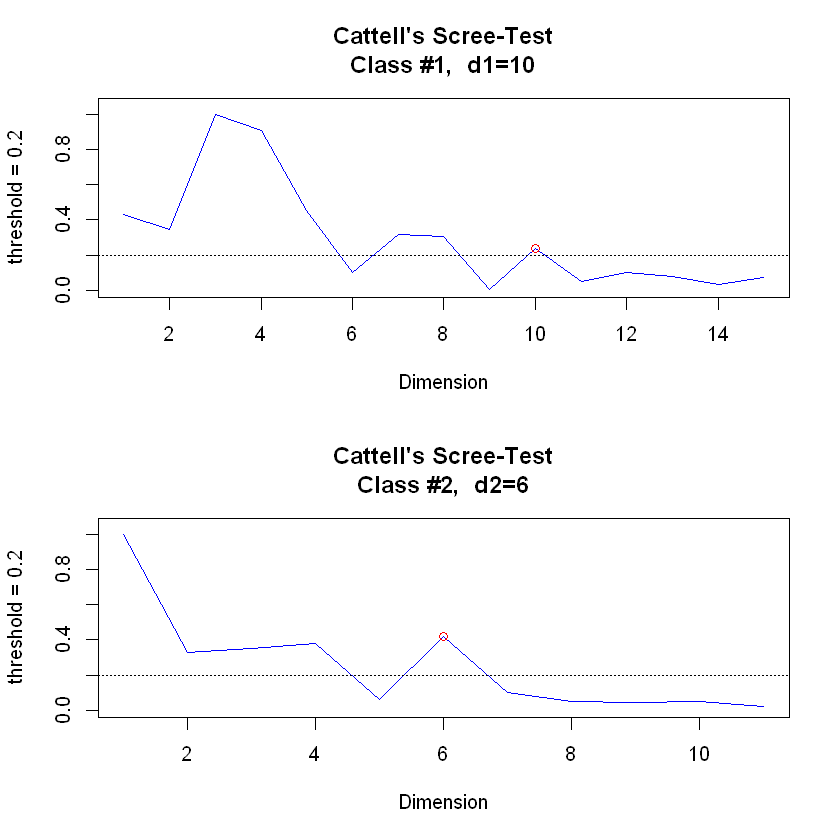

In [65]:
run <- readline("hddc (y/n): ")

if (run == "y"){
    clus1 <- hddc(clinical5, K = 1:10, model = "ALL", threshold = 0.2,
    criterion = "bic", com_dim = 5, itermax = 200, eps = 0.001,
    algo = "EM", d_select = "Cattell", init = "kmeans", init.vector,
    show = TRUE, mini.nb = c(5, 10), scaling = FALSE, min.individuals = 2,
    noise.ctrl = 1e-08, mc.cores = 1, nb.rep = 1, keepAllRes = TRUE,
    kmeans.control = list(), d_max = 100, d = "B")

    plot(clus1)
}

---
### SAM (clinical_p)

In [140]:
indi <- which(!is.na(clinical_p$focality))
set.seed(12345)
sam.out1 <- sam(t(clinical_p[indi, 11:ncol(clinical_p)]), clinical_p$focality[indi], B = 1000)

Warning message:
"There are 338 genes with at least one missing expression value.
The NAs are replaced by the gene-wise mean."

In [141]:
sam.out1

SAM Analysis for the Two-Class Unpaired Case Assuming Unequal Variances 
 
   Delta    p0   False Called    FDR
1    0.1 0.796 246.671    273 0.7190
2    0.2 0.796 139.317    179 0.6193
3    0.3 0.796  42.919     73 0.4678
4    0.4 0.796  18.178     42 0.3444
5    0.5 0.796   4.964     15 0.2633
6    0.6 0.796   2.355     10 0.1874
7    0.7 0.796   0.726      7 0.0825
8    0.8 0.796   0.726      7 0.0825
9    0.9 0.796   0.412      5 0.0656
10   1.0 0.796       0      0      0

To obtain a SAM plot, delta has to be specified in plot(object,delta,...). 


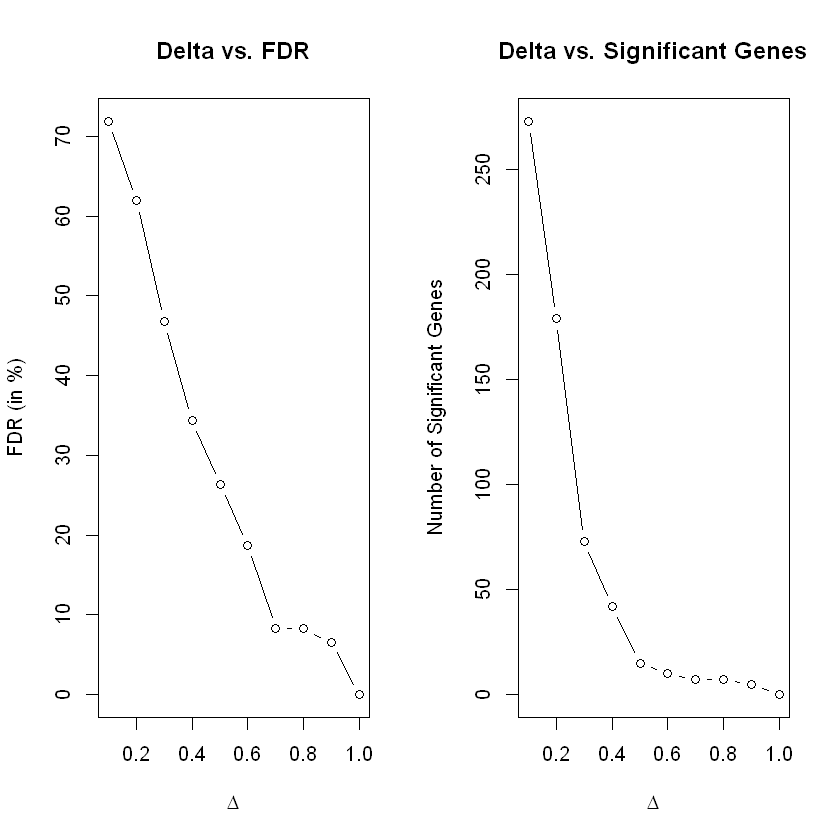

In [52]:
plot(sam.out1)

In [142]:
#data output
png("Delta vs DEG.png",width = 800, height = 800)

plot(sam.out1)

dev.off()

To obtain a SAM plot, delta has to be specified in plot(object,delta,...). 


png 
  2

In [143]:
#delta finding
fin.Delta <- findDelta(sam.out1, fdr = 0.0825)

The threshold seems to be at 
     Delta Called      FDR
5 0.846464      7 0.082528
6 0.846465      5 0.065567


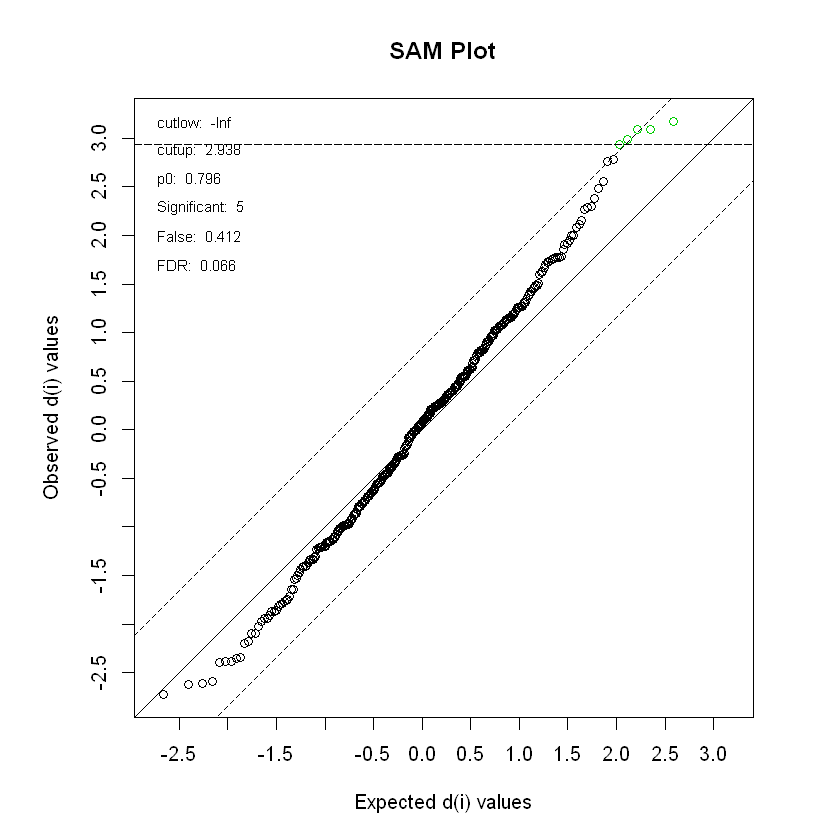

In [144]:
plot(sam.out1, fin.Delta[2, 1], pos.stats=1, main="SAM Plot")

In [145]:
gene.sig1 <- summary(sam.out1, fin.Delta[2, 1])@row.sig.genes

pval <- sam.out1@p.value
pi0 <- pi0.est(pval)$p0
qval <- qvalue.cal(pval, pi0)

pval.selected <- pval[names(pval) %in% names(gene.sig1)]
qval.selected <- qval[names(qval) %in% names(gene.sig1)]

pval.selected <- pval.selected[order(names(pval.selected))]
qval.selected <- qval.selected[order(names(qval.selected))]

write.csv(gene.sig1, "sig.genes1.csv")
save(gene.sig1, file = "gene.sig1.RData")

---
### fold change

In [146]:
head(clinical_p[indi, 11:ncol(clinical_p)-1])
clinical_p$focality[indi]

tmp_p <- clinical_p[indi, 11:ncol(clinical_p)-1]

focal.mean1 <- apply(tmp_p[tmp_p$focality == 1, 2:ncol(tmp_p)], 2, function(x) mean(x, na.rm=TRUE))
focal.mean2 <- apply(tmp_p[tmp_p$focality == 0, 2:ncol(tmp_p)], 2, function(x) mean(x, na.rm=TRUE))
fold.change <- focal.mean1/focal.mean2

fold.change.selected <- fold.change[names(fold.change) %in% names(gene.sig1)]
fold.change.selected <- fold.change.selected[order(names(fold.change.selected))]

,focality,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,hsa-let-7g,hsa-let-7i,hsa-mir-1-2,hsa-mir-100,hsa-mir-101-1,hsa-mir-101-2,hsa-mir-103-1,hsa-mir-103-2,hsa-mir-106a,hsa-mir-106b,hsa-mir-107,hsa-mir-10a,hsa-mir-10b,hsa-mir-1179,hsa-mir-1180,hsa-mir-1224,hsa-mir-1226,hsa-mir-1247,hsa-mir-1248,hsa-mir-1249,hsa-mir-1251,hsa-mir-1254,hsa-mir-125a,hsa-mir-125b-1,hsa-mir-125b-2,hsa-mir-126,hsa-mir-1266,hsa-mir-127,hsa-mir-1270-1,hsa-mir-1270-2,hsa-mir-1271,hsa-mir-1274b,hsa-mir-1277,hsa-mir-128-1,hsa-mir-128-2,hsa-mir-1287,hsa-mir-1288,hsa-mir-129-1,hsa-mir-129-2,hsa-mir-1291,hsa-mir-1292,hsa-mir-1296,hsa-mir-1301,hsa-mir-1306,hsa-mir-1307,hsa-mir-130a,hsa-mir-130b,hsa-mir-132,hsa-mir-133a-1,hsa-mir-133b,hsa-mir-134,hsa-mir-135a-1,hsa-mir-135a-2,hsa-mir-135b,hsa-mir-136,hsa-mir-138-1,hsa-mir-138-2,hsa-mir-139,hsa-mir-140,hsa-mir-141,hsa-mir-142,hsa-mir-143,hsa-mir-144,hsa-mir-145,hsa-mir-1468,hsa-mir-146a,hsa-mir-146b,hsa-mir-148a,hsa-mir-148b,hsa-mir-149,hsa-mir-150,hsa-mir-151,hsa-mir-152,hsa-mir-153-2,hsa-mir-155,hsa-mir-15a,hsa-mir-15b,hsa-mir-16-1,hsa-mir-16-2,hsa-mir-17,hsa-mir-181a-1,hsa-mir-181a-2,hsa-mir-181b-1,hsa-mir-181b-2,hsa-mir-181c,hsa-mir-181d,hsa-mir-182,hsa-mir-183,hsa-mir-185,hsa-mir-186,...,hsa-mir-421,hsa-mir-423,hsa-mir-424,hsa-mir-425,hsa-mir-429,hsa-mir-431,hsa-mir-4326,hsa-mir-450a-1,hsa-mir-450a-2,hsa-mir-450b,hsa-mir-451,hsa-mir-452,hsa-mir-454,hsa-mir-455,hsa-mir-484,hsa-mir-486,hsa-mir-491,hsa-mir-493,hsa-mir-495,hsa-mir-497,hsa-mir-499,hsa-mir-500a,hsa-mir-500b,hsa-mir-501,hsa-mir-502,hsa-mir-503,hsa-mir-505,hsa-mir-508,hsa-mir-509-1,hsa-mir-509-2,hsa-mir-509-3,hsa-mir-511-1,hsa-mir-511-2,hsa-mir-514-1,hsa-mir-514-2,hsa-mir-514-3,hsa-mir-532,hsa-mir-542,hsa-mir-548b,hsa-mir-548v,hsa-mir-550a-1,hsa-mir-550a-2,hsa-mir-551b,hsa-mir-574,hsa-mir-576,hsa-mir-577,hsa-mir-582,hsa-mir-584,hsa-mir-585,hsa-mir-589,hsa-mir-590,hsa-mir-592,hsa-mir-598,hsa-mir-616,hsa-mir-624,hsa-mir-625,hsa-mir-627,hsa-mir-628,hsa-mir-629,hsa-mir-639,hsa-mir-642a,hsa-mir-643,hsa-mir-651,hsa-mir-652,hsa-mir-653,hsa-mir-654,hsa-mir-659,hsa-mir-660,hsa-mir-664,hsa-mir-671,hsa-mir-675,hsa-mir-676,hsa-mir-7-1,hsa-mir-7-2,hsa-mir-708,hsa-mir-744,hsa-mir-758,hsa-mir-760,hsa-mir-766,hsa-mir-769,hsa-mir-874,hsa-mir-877,hsa-mir-887,hsa-mir-889,hsa-mir-891a,hsa-mir-9-1,hsa-mir-9-2,hsa-mir-92a-1,hsa-mir-92a-2,hsa-mir-92b,hsa-mir-93,hsa-mir-935,hsa-mir-937,hsa-mir-939,hsa-mir-940,hsa-mir-942,hsa-mir-95,hsa-mir-96,hsa-mir-98,hsa-mir-99a
13,1,15322.36,30569.49,15288.955,11595.919,6099.292,909.0471,2626.395,84.55951,37718.07,1312.4206,1957.689,21.366492,12434.521,26190.40,232.70052,32431.87,6.733682,7.122164,400.2656,68.24328,12890.340,25100.45,1.165445,23.43839,1.683421,0.647469,17.481675,1.035951,0.647469,52.44503,0.258988,2035.773,3840.141,43.38045,5683.875,19.03560,77.43735,2.719372,2.330890,1.812914,1.294939,1.553927,50.24363,32.37347,26.28726,0.776963,0.258988,0.258988,0.517976,0.517976,5.438743,9.712042,5.827225,717.9141,139.98290,8.028621,342.77033,11.913438,1.165445,25.639790,1080.62652,62.54555,398.9707,4.143805,16.575218,10.359511,145.29215,1470.2736,1433.497,3151.2338,76709.85,116.41501,1769.6635,15.539267,162.51483,69600.247,30743.40,215.9958,8.546597,1351.5277,2899.757,243.9665,12.690401,821.63874,210.9455,294.8576,690.9794,6.215707,446.3654,4342.578,4216.839,1257.3857,16.96370,218.9742,84.55951,7585.752,2110.880,77.04887,320.1089,...,2.201396,209.0031,814.12809,126.25654,11.39546,0.776963,5.697731,25.380803,27.582199,66.818848,427.9773,108.25689,8.287609,100.09878,32.63246,80.54520,8.158115,1.812914,1.424433,14.762304,1.035951,210.5571,5.956719,23.43839,8.158115,17.352181,48.17173,46.488307,4.143805,2.460384,3.755323,2.071902,2.071902,6.086213,7.251658,6.604188,674.1452,1844.8995,0.906457,0.129494,2.201396,1.424433,17.870157,104.89005,11.783944,2.201396,85.07749,45.97033,5.179756,32.37347,13.855846,1.683421,148.78848,1.165445,1.035951,197.60768,1.553927,18.77661,122

[1] 1 1 0 1 0 1 1 0 1 1 0 0 1 1 0 0 1 1 1 0 1 1 0 1 0 0 0 1 0 1 1 1 1 1 0 1 0
 [38] 1 1 0 1 1 1 1 0 0 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 0
 [75] 1 1 0 1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0
[112] 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1
[149] 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0 0 0 1 1 1 0 1 0 0 0 1 1 0 1
[186] 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 0 0 0
[223] 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1

---

In [147]:
summary.ststs <- data.frame(gene = names(pval.selected),
                            p.value = as.numeric(pval.selected),
                            q.value = as.numeric(qval.selected),
                            fold.change = as.numeric(fold.change.selected))

write.csv(summary.ststs, "summary.ststs.csv", row.names = FALSE)

---
### clinical data output

In [59]:
clin <- clinical_p[, c(1:10)]
clin1 <- clinical_p[, names(gene.sig1)]
fin.clin <- cbind(clin, clin1)
write.csv(fin.clin, file = "clinical.final.csv")

clin <- clinical_n[, c(1:10)]
clin1 <- clinical_n[, names(gene.sig1)]
fin.clin <- cbind(clin, clin1)
write.csv(fin.clin, file = "clinical.final.csv")

---
### plot

In [60]:
clinical01 <- clinical_p[indi,]
clinical02 <- clinical01[clinical01$focality == 1, names(gene.sig1)]
clinical03 <- clinical01[clinical01$focality == 0, names(gene.sig1)]

diff <- apply(clinical02, 2, median, na.rm = TRUE) - apply(clinical03, 2, median, na.rm = TRUE)
sum(diff < 0)
sum(diff >= 0)

write.csv(diff, "sig.genes.csv")

[1] 0

[1] 5

To obtain a SAM plot, delta has to be specified in plot(object,delta,...). 


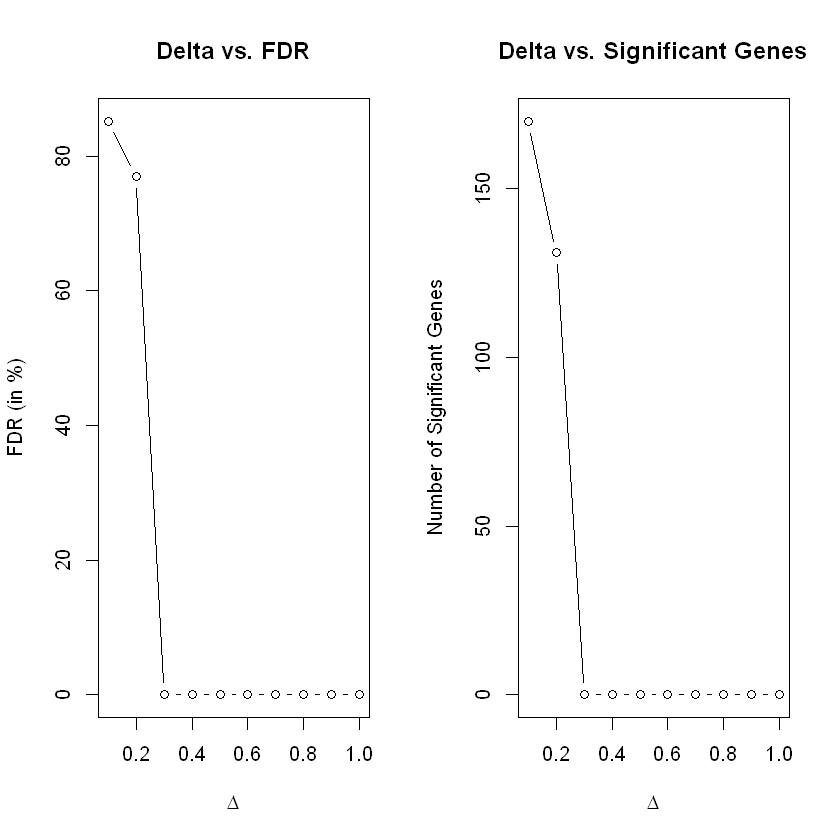

In [61]:
#SAM  - clunical_n
indi <- which(!is.na(clinical_n$focality))
set.seed(12345)
sam.out1 <- sam(t(clinical_n[indi, 11:ncol(clinical_n)]), clinical_n$focality[indi], B = 1000)
plot(sam.out1)

In [62]:
sam.out1

SAM Analysis for the Two-Class Unpaired Case Assuming Unequal Variances 
 
   Delta   p0   False Called   FDR
1    0.1 0.95 152.548    170 0.852
2    0.2 0.95 106.332    131 0.771
3    0.3 0.95       0      0     0
4    0.4 0.95       0      0     0
5    0.5 0.95       0      0     0
6    0.6 0.95       0      0     0
7    0.7 0.95       0      0     0
8    0.8 0.95       0      0     0
9    0.9 0.95       0      0     0
10   1.0 0.95       0      0     0

The threshold seems to be at 
     Delta Called      FDR
5 0.230415    123 0.746196
6 0.230416      0 0.000000


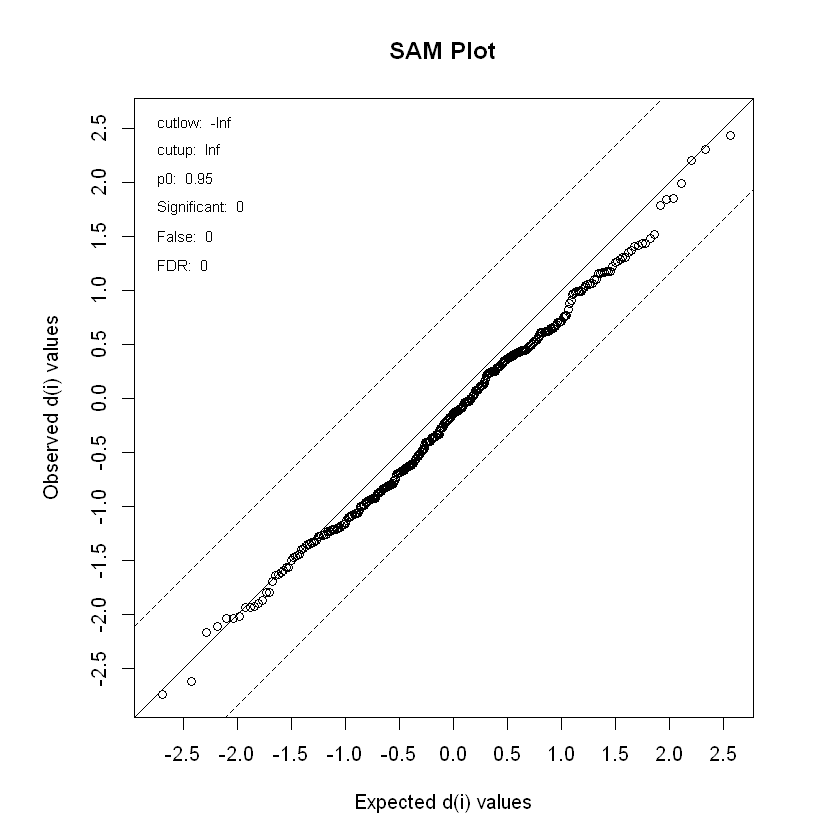

In [63]:
findDelta(sam.out1, fdr = 0.0825)
plot(sam.out1, fin.Delta[2,1], pos.stats=1, main="SAM Plot")
gene.sig1 <- summary(sam.out1, 1.098185)@row.sig.genes

write.csv(gene.sig1, "sig.genes.csv")

In [64]:
###########plot
clinical01 <- clinical_p[indi,]
clinical02 <- clinical01[clinical01$focality == 1, names(gene.sig1)]
clinical03 <- clinical01[clinical01$focality == 0, names(gene.sig1)]

diff <- apply(clinical02, 2, median, na.rm = TRUE) - apply(clinical03, 2, median, na.rm = TRUE)
sum(diff < 0)
sum(diff >= 0)

write.csv(diff, "sig.genes.csv")

[1] 0

[1] 0